# Import Libraries

In [464]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings 

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# libraries for Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings("ignore")

In [465]:
# Set global plots style
plt.style.use('ggplot')

In [466]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

# Load Data

In [467]:
# Define file path
file_path_train = os.getcwd()+'/train.csv'
file_path_test = os.getcwd()+'/test.csv'

# Load train and test data
train_raw = pd.read_csv(file_path_train)
test_raw = pd.read_csv(file_path_test)

In [468]:
print(f'The train dataset has {train_raw.shape[0]} rows and {train_raw.shape[1]} columns.') 

The train dataset has 6895 rows and 70 columns.


In [469]:
print(f'The test dataset has {test_raw.shape[0]} rows and {test_raw.shape[1]} columns.') 

The test dataset has 767 rows and 69 columns.


In [470]:
# Concatenate train and test data
df_raw = pd.concat([train_raw, test_raw], ignore_index=True)

# Data Exploration

In [471]:
# Check the list of columns
df_raw.columns

Index(['id', 'short_name', 'overall', 'potential', 'value_eur', 'wage_eur',
       'birthday_date', 'height_cm', 'weight_kg', 'club_name', 'league_name',
       'league_level', 'club_jersey_number', 'club_loaned_from', 'club_joined',
       'club_contract_valid_until', 'nationality_name', 'nation_jersey_number',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'player_tags', 'player_traits', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'pow

In [472]:
# Display basic information about the dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           7662 non-null   int64  
 1   short_name                   7662 non-null   object 
 2   overall                      7662 non-null   int64  
 3   potential                    7662 non-null   int64  
 4   value_eur                    7657 non-null   float64
 5   wage_eur                     7662 non-null   int64  
 6   birthday_date                7662 non-null   object 
 7   height_cm                    7662 non-null   int64  
 8   weight_kg                    7662 non-null   int64  
 9   club_name                    7662 non-null   object 
 10  league_name                  7662 non-null   object 
 11  league_level                 7662 non-null   int64  
 12  club_jersey_number           7662 non-null   int64  
 13  club_loaned_from  

## Check for Missing Values

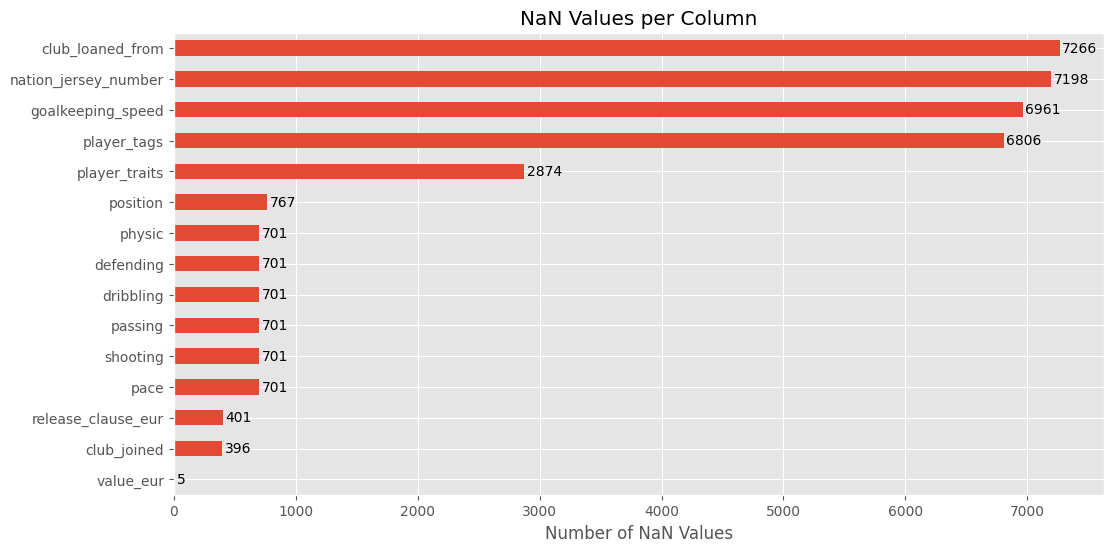

In [473]:
# Check for NaN values and filter columns with more than 0 NaN
na_counts = df_raw.isna().sum()
columns_with_nan = na_counts[na_counts > 0].index
df_missing = na_counts[columns_with_nan].sort_values(ascending=True)

ax = df_missing.plot(kind='barh', figsize=(12, 6))
plt.title('NaN Values per Column')
plt.xlabel('Number of NaN Values')

# Add numbers on the right side of each bar
for i, v in enumerate(df_missing):
    ax.text(v + 20, i, str(v), ha='left', va='center')

plt.show()

Columns that miss more than 80% of the data:
- club_loaned_from
- nation_jersey_number
- goalkeeping_speed
- player_tags

As the goalkeeping_speed most likely is related to the goal keeper characteristics only, it needs more investigation to check if it is populated only for goal keepers or if it also has missing data.

Columns club_loaned_from, nation_jersey_number, player_tags will be dropped in the Data Preparation part due to the high missing values number.

In [474]:
# Checking if goalkeeping_speed is imputed only for position == GK (in the train data only as the test data doesn't have the position column)

res = train_raw[train_raw['position'] == 'GK']['goalkeeping_speed'].notnull().all()
print(f'All values for GK are imputed: {res}')

res1 = train_raw[train_raw['position'] != 'GK']['goalkeeping_speed'].isnull().all()
print(f'No values of goalkeeping_speed for all the other positons are imputed: {res1}')

All values for GK are imputed: True
No values of goalkeeping_speed for all the other positons are imputed: True


Therefore, we see that goalkeeping_speed is imputed only for the position of GK, for all the other positions it's NaN.

In [475]:
na_counts_GK = df_raw[df_raw['position'] == 'GK'].isna().sum().sort_values(ascending=True)
print('Missing values for the GK position: \n')
print(na_counts_GK[na_counts_GK > 0])

Missing values for the GK position: 

release_clause_eur       33
club_joined              33
player_traits           251
nation_jersey_number    571
club_loaned_from        598
pace                    631
shooting                631
passing                 631
dribbling               631
defending               631
player_tags             631
physic                  631
dtype: int64


Also we see that for the GK position such columns as pace, shooting, passing, dribbling, defending, player_tags, physic are completely missing, so we assume that those are not relevant for GK.

## Numerical Variables Exploration

In [476]:
# Summary statistics for numerical columns
df_raw.describe()

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,7662.000000,7662.000000,7662.000000,7.657000e+03,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,464.000000,7662.000000,7662.000000,7662.000000,7.261000e+03,...,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,701.000000
mean,223616.285435,68.842600,72.048029,4.331453e+06,12030.253198,181.484338,75.552467,1.361655,16.525320,2022.763508,12.056034,2.996346,2.451188,1.147481,8.187938e+06,...,59.815714,51.504960,53.130645,56.939441,49.895589,61.901592,51.349517,52.304098,49.800052,15.903289,15.672409,15.545680,15.813234,16.011877,40.375178
std,26710.529813,5.951663,6.074939,1.045019e+07,24385.866372,6.860952,7.042419,0.761018,15.487419,1.207030,6.902991,0.685301,0.780693,0.470143,2.044656e+07,...,16.272640,20.123523,19.313219,13.559154,15.668827,10.886174,19.658360,20.918691,20.638862,17.466642,16.767293,16.319634,17.191808,17.877237,10.194699
min,41.000000,48.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,3.900000e+04,...,11.000000,6.000000,2.000000,10.000000,8.000000,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,207642.250000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,6.000000,3.000000,2.000000,1.000000,1.100000e+06,...,51.000000,33.000000,42.000000,48.000000,40.000000,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000,33.000000
50%,228152.500000,68.000000,72.000000,1.400000e+06,4000.000000,182.000000,75.000000,1.000000,13.000000,2023.000000,12.000000,3.000000,2.000000,1.000000,2.300000e+06,...,63.000000,59.000000,59.000000,59.000000,50.000000,63.000000,58.000000,61.000000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000,42.000000
75%,242513.500000,72.000000,76.000000,3.000000e+06,12000.000000,186.000000,80.000000,1.000000,22.000000,2024.000000,18.000000,3.000000,3.000000,1.000000,5.400000e+06,...,72.000000,67.000000,67.000000,67.000000,62.000000,69.000000,66.000000,68.000000,66.000000,14.000000,14.000000,14.000000,14.000000,14.000000,47.000000
max,264481.000000,93.000000,95.000000,1.940000e+08,350000.000000,203.000000,103.000000,5.000000,99.000000,2031.000000,28.000000,5.000000,5.000000,5.000000,3.735000e+08,...,95.000000,91.000000,96.000000,95.000000,93.000000,96.000000,92.000000,93.000000,92.000000,91.000000,92.000000,93.000000,92.000000,90.000000,65.000000


Columns value_eur and wage_eur have high standard deviations, suggesting the presence of extreme values (potential outliers). It will be explored more in the further analysis.

Columns height_cm and weight_kg have moderate standard deviations, indicating some variability in player physical attributes. The relationships between player posisions and the phisical attributes will be studied later as well.

All the other columns have relatively law standard deviations and are not a cause for concern.

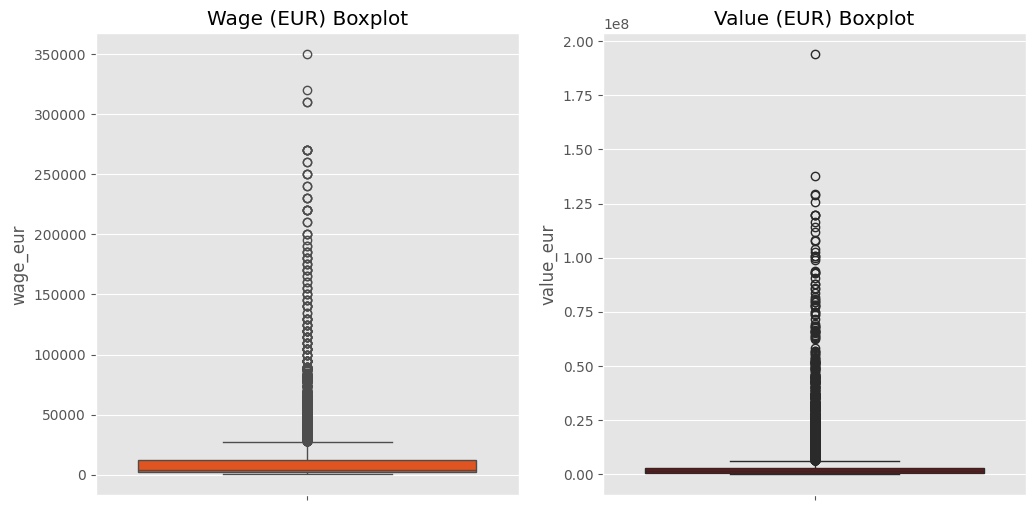

In [477]:
# Check value_eur and wage_eur columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(df_raw['wage_eur'], ax=axes[0], color='orangered')
axes[0].set_title('Wage (EUR) Boxplot')

sns.boxplot(df_raw['value_eur'], ax=axes[1], color='darkred')
axes[1].set_title('Value (EUR) Boxplot')

plt.show()

As we can see in the boxplots above, both height_cm and weight_kg variables have outliers. We will remove those in the data preparation part.

Let's take a look at the distributions of both columns:

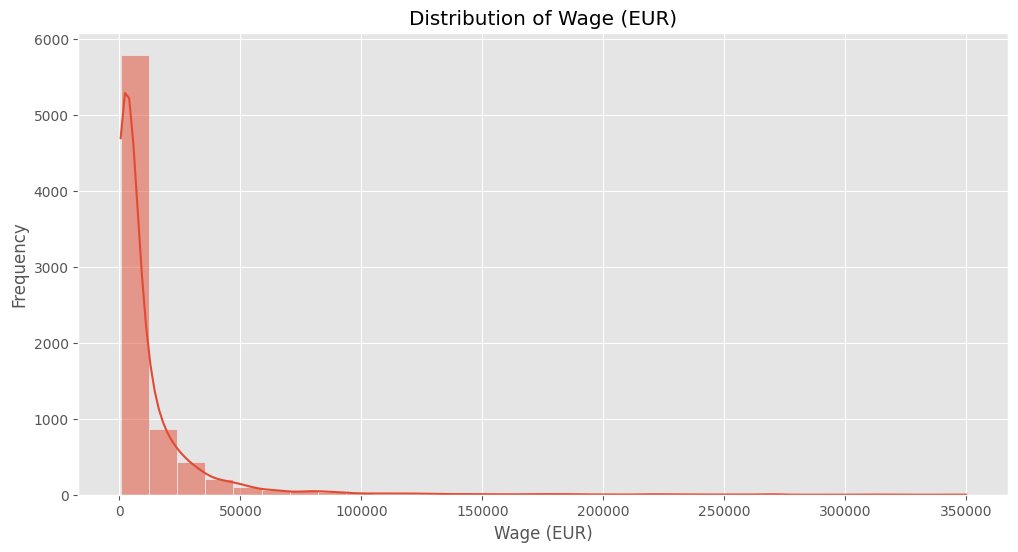

In [478]:
# Visualize the distribution of the wage_eur variable

plt.figure(figsize=(12, 6))
sns.histplot(df_raw['wage_eur'], bins=30, kde=True)
plt.title('Distribution of Wage (EUR)')
plt.xlabel('Wage (EUR)')
plt.ylabel('Frequency')
plt.show()

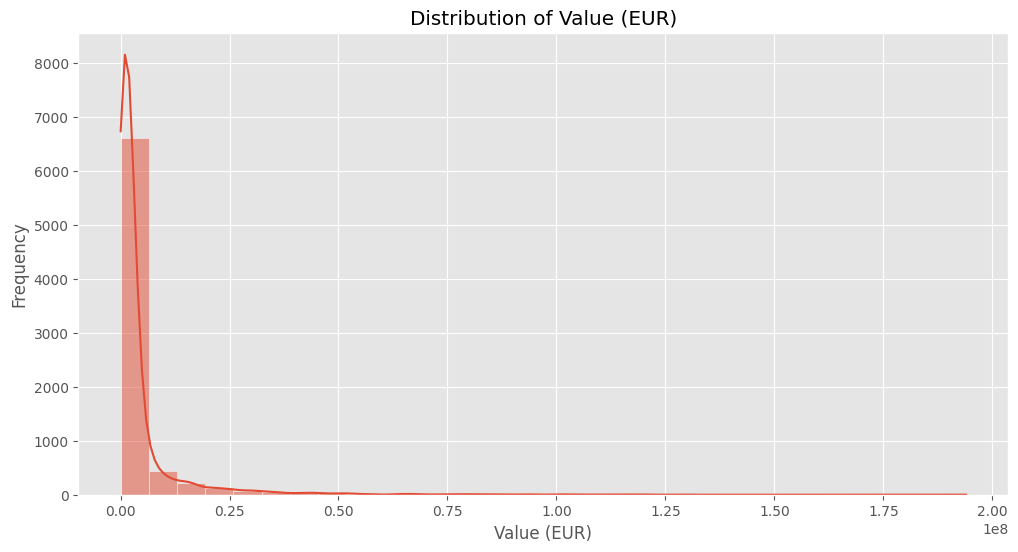

In [479]:
# Visualize the distribution of the value_eur variable

plt.figure(figsize=(12, 6))
sns.histplot(df_raw['value_eur'], bins=30, kde=True)
plt.title('Distribution of Value (EUR)')
plt.xlabel('Value (EUR)')
plt.ylabel('Frequency')
plt.show()

Both height_cm and weight_kg are highly right skewed. The distributions should be checked again after the outliers are removed.

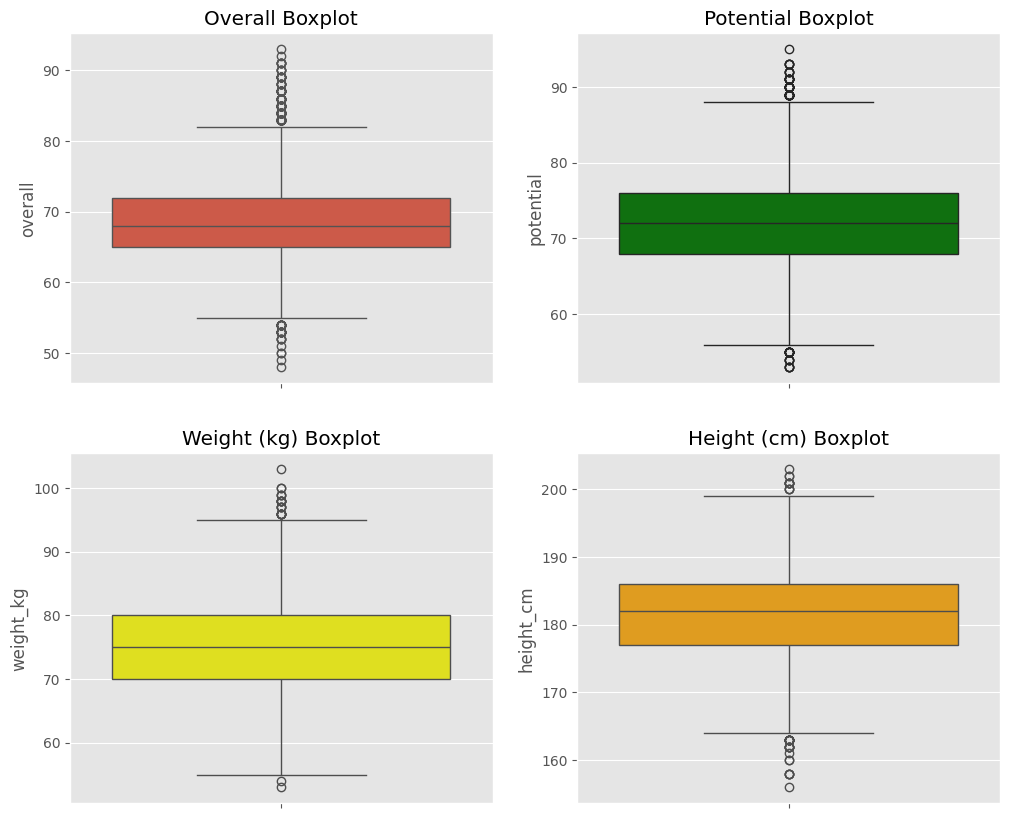

In [480]:
# Check other main numerical columns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(df_raw['overall'], ax = axes[0,0])
axes[0,0].set_title('Overall Boxplot')

sns.boxplot(df_raw['potential'], ax = axes[0,1], color='green')
axes[0,1].set_title('Potential Boxplot')

sns.boxplot(df_raw['weight_kg'], ax = axes[1,0], color = 'yellow')
axes[1,0].set_title('Weight (kg) Boxplot')

sns.boxplot(df_raw['height_cm'], ax = axes[1,1], color='orange')
axes[1,1].set_title('Height (cm) Boxplot')

plt.show()

There might be some outliers in the overall, potential, weight_kg, height_cm columns, too. We will check later if it's needed to remove them from the data.


Let's take a look at correlations between the numerical variables.

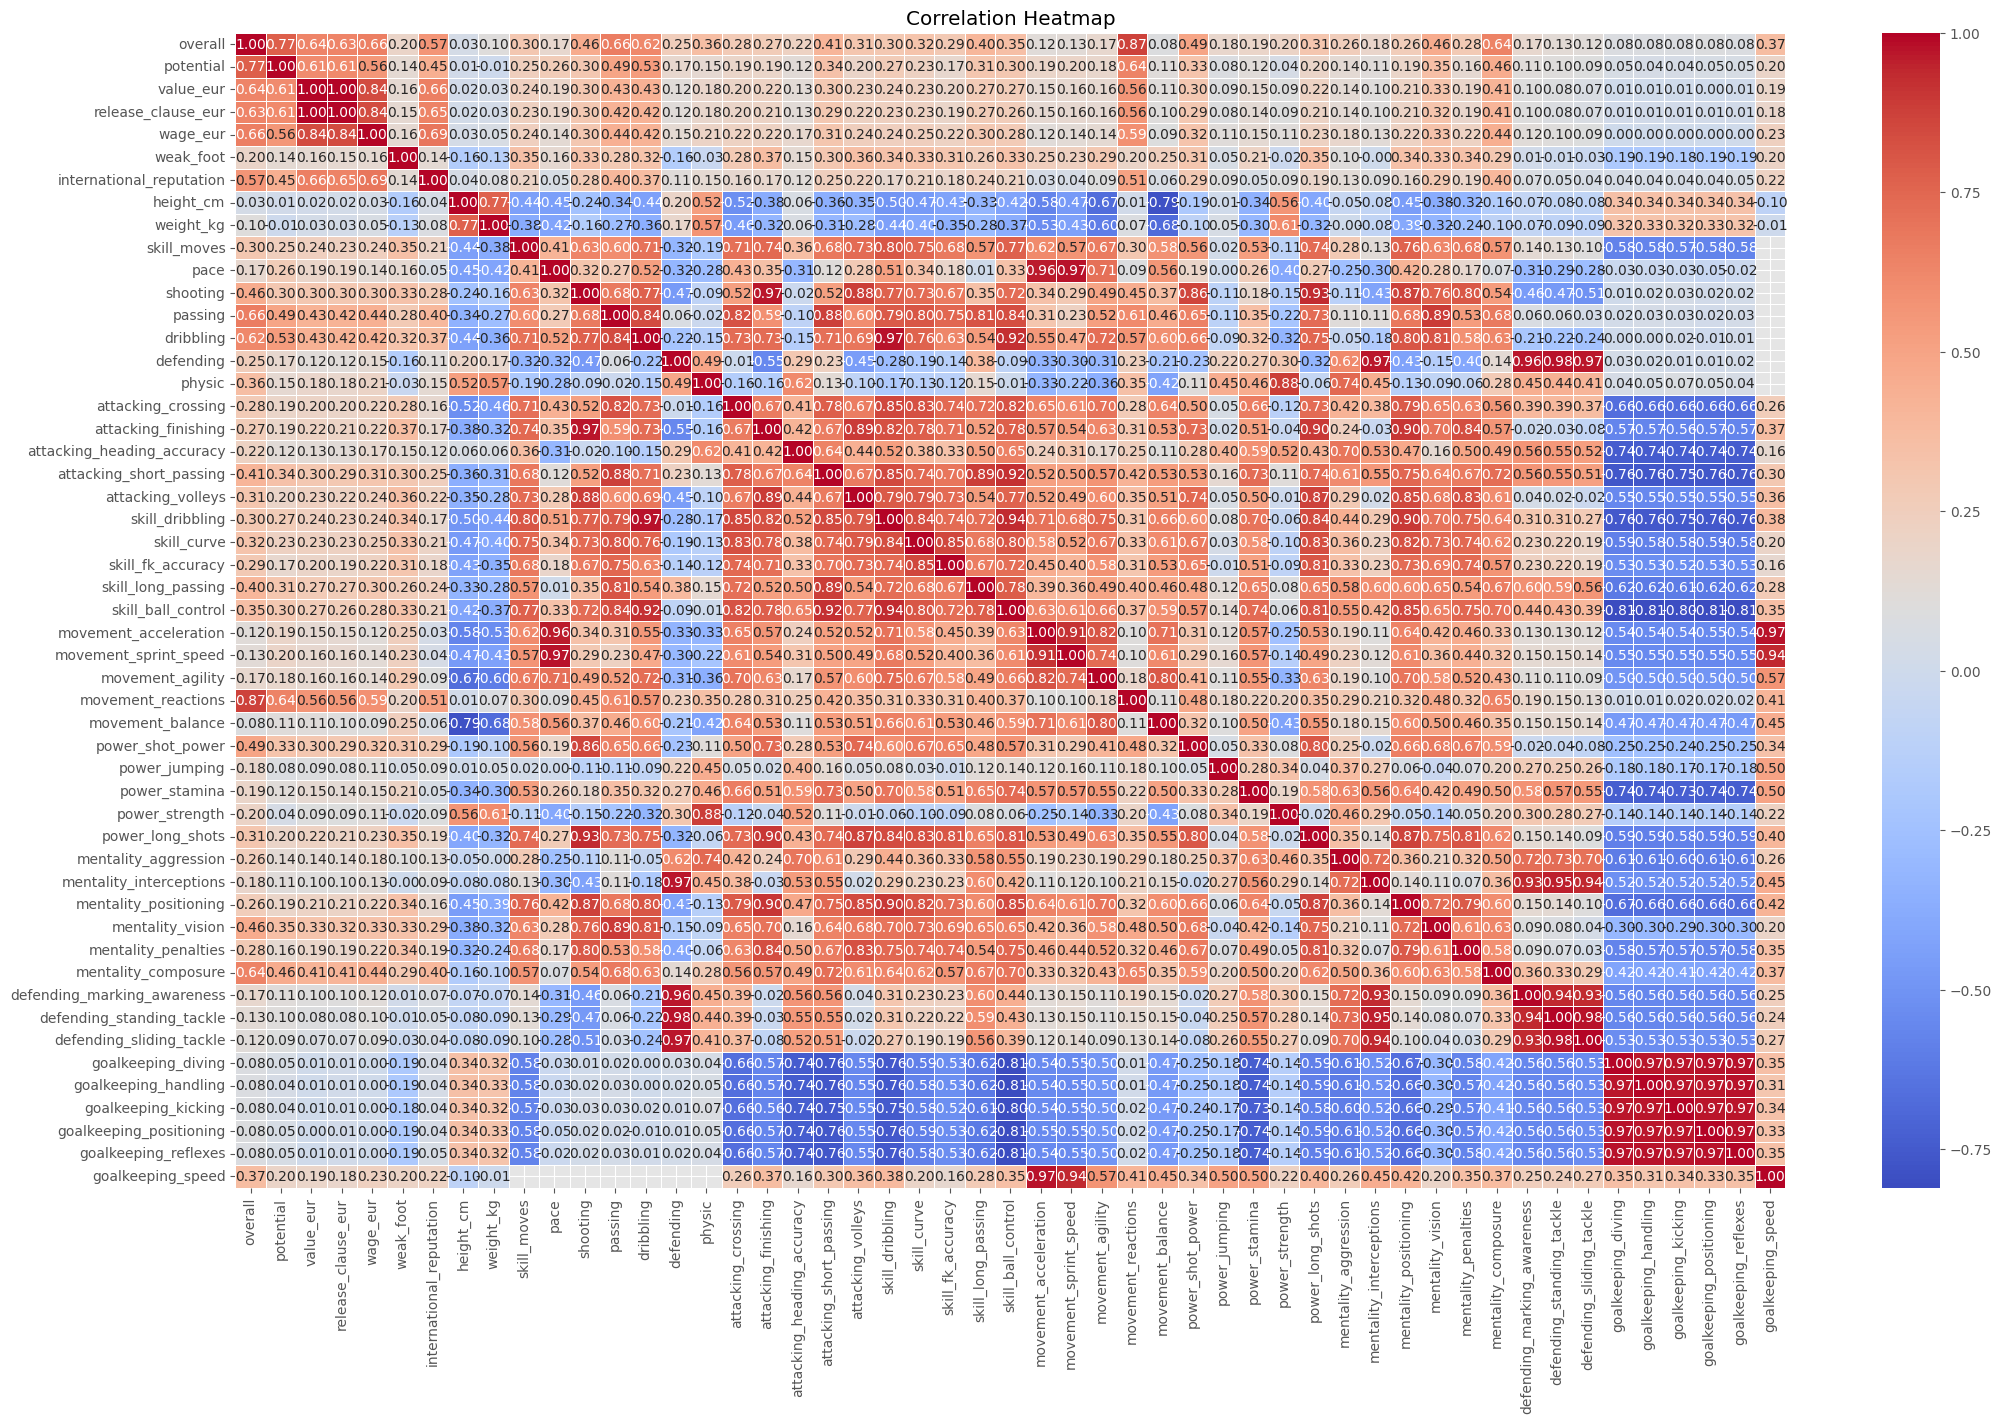

In [481]:
# Correlation heatmap

cols = ['overall', 'potential', 'value_eur', 'release_clause_eur', 'wage_eur', 'weak_foot', 'international_reputation',
    'height_cm', 'weight_kg','skill_moves', 'pace', 'shooting', 'passing', 'dribbling',
    'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
    'attacking_heading_accuracy', 'attacking_short_passing',
    'attacking_volleys', 'skill_dribbling', 'skill_curve',
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'movement_reactions', 'movement_balance', 'power_shot_power',
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions',
    'mentality_positioning', 'mentality_vision', 'mentality_penalties',
    'mentality_composure', 'defending_marking_awareness',
    'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving',
    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
    'goalkeeping_reflexes', 'goalkeeping_speed']

correlation_matrix = df_raw[cols].corr()
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### Insights from the correlation matrix:
- all goalkeeping variables (except for goalkeeping_speed) are highly positively correlated with each other.
- goalkeeping_speed is highly correlated to movement_acceleration ans movement_sprint_speed.
- defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle are higly positively correlated with each other, and also there is a high correlation to variables defending, mentality_interceptions.
- power_long_shots and attacking_finishing are highly positively correlated with shooting.
- movement_balance is highly negatively correlated with height_cm.
- movement_acceleration and movement_sprint_speed are highly positively correlated with the pace variable
- both skill_ball_control and skill_dribbling are highly positively correlated with defending and attacking_short_passing.
- release_clause_eur is perfectly correlated to value_err. As release_clause_eur has some missing values, it can be either droppped because of high correlecation with value_err or imputed using value_err -> we will decide later.

We will select the variables we want to keep/drop based on the correlations in the data preparation part.

## Categorical Variables Exploration

In [482]:
# # Summary table for categorical variables

# def categorical_summary(df):
#     # Initialize an empty DataFrame to store the results
#     cat_summary_df = pd.DataFrame(columns=['Variable', 'Data Type', 'Unique Values', 'Missing Values (%)', 'Top Values'])
    
#     # Iterate over all columns and fill the summary DataFrame for categorical columns
#     for column in df.columns:
#         if df[column].dtype == 'O':
#             unique_values = df[column].nunique()
#             missing_percentage = (df[column].isnull().mean()) * 100
#             top_values = df[column].value_counts().head().index.tolist()

#             # Add a new row to the summary DataFrame
#             cat_summary_df = cat_summary_df.append({
#                 'Variable': column,
#                 'Data Type': df[column].dtype,
#                 'Unique Values': unique_values,
#                 'Missing Values (%)': missing_percentage,
#                 'Top Values': top_values
#             }, ignore_index=True)
    
#     return cat_summary_df

# # Example usage:
# # Assuming your DataFrame is named 'your_dataframe'
# summary_df = categorical_summary(df_raw)
# display(summary_df)


As the position of the player does not depend on the birthday date, it is possible that there is relationship between the age of the player (or year born) and the position.

In [483]:
# Convert 'birthday_date' to datetime format
df_raw['birthday_date'] = pd.to_datetime(df_raw['birthday_date'])

# Extract the year and create a new column 'year_born'
df_raw['year_born'] = df_raw['birthday_date'].dt.year

The variable body_type might be the combination of height_cm and weight_cm. Let's take a look at the chart to see if this hypothesis is true. If yes, we can remove the body_type column from our dataset.

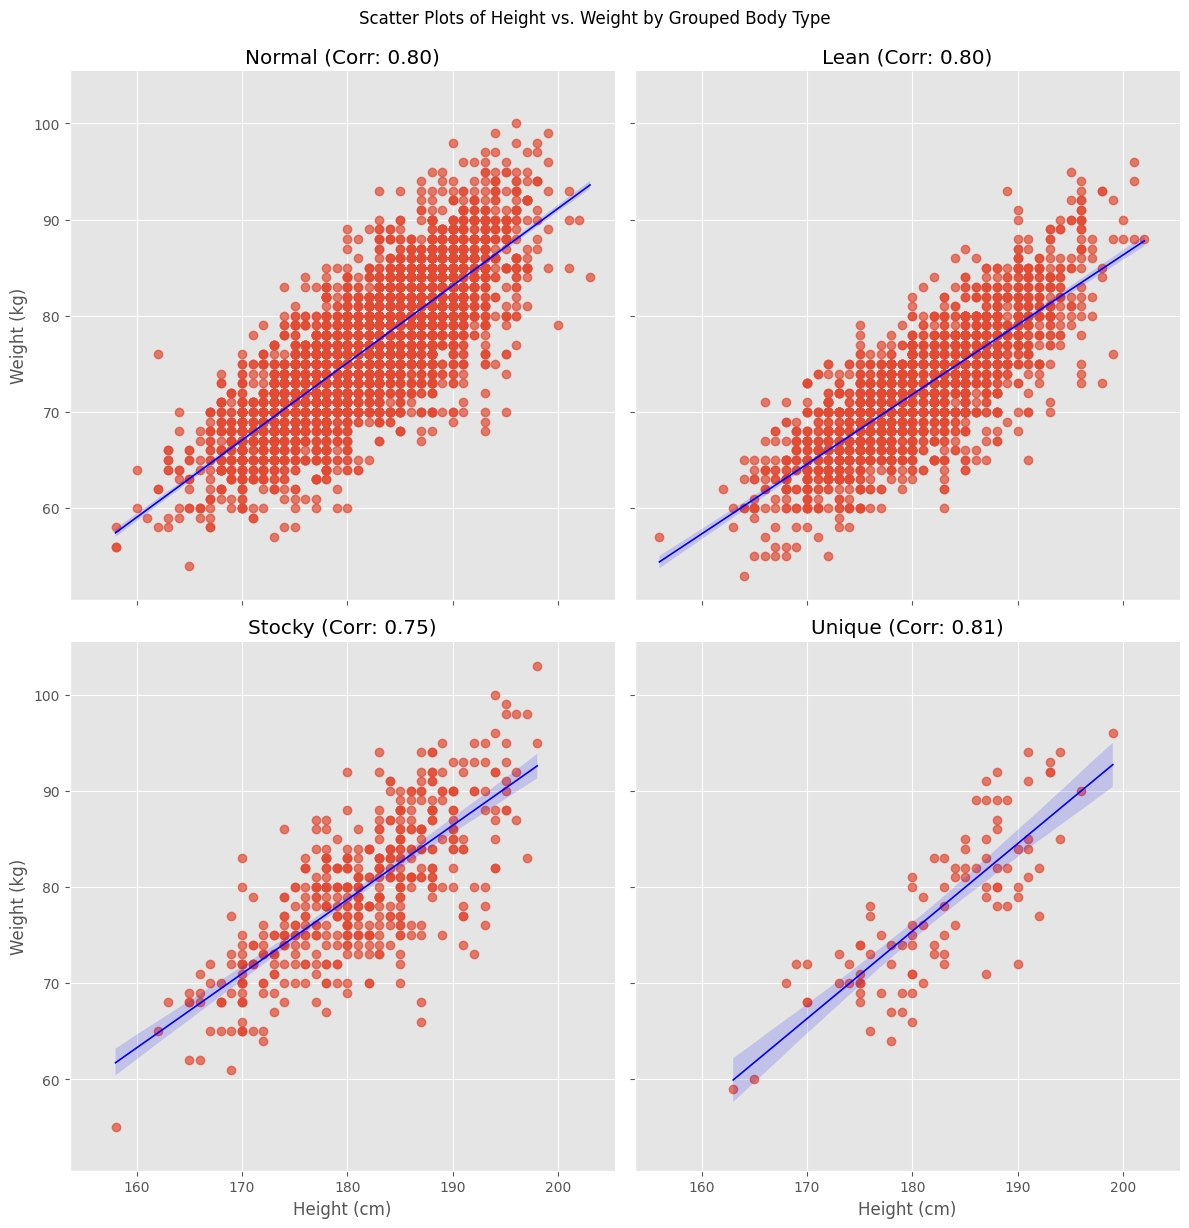

In [484]:
# Create a new column 'body_type_grouped' based on the existing 'body_type' values
df_raw['body_type_grouped'] = df_raw['body_type'].apply(lambda x: 'Normal' if 'Normal' in x else ('Lean' if 'Lean' in x else ('Stocky' if 'Stocky' in x else 'Unique')))

# Create a FacetGrid with separate subplots for each grouped body type
g = sns.FacetGrid(df_raw, col='body_type_grouped', col_wrap=2, height=6)
g.map(sns.regplot, 'height_cm', 'weight_kg', scatter_kws={'alpha': 0.7}, line_kws={'color': 'blue', 'linewidth': 1.2})  # Use the alpha parameter to control point transparency
g.set_axis_labels('Height (cm)', 'Weight (kg)')

# Add a title with correlation score to each subplot
for ax in g.axes.flat:
    body_type = ax.get_title().split('=')[-1].strip()
    subset = df_raw[df_raw['body_type_grouped'] == body_type]
    correlation = subset[['height_cm', 'weight_kg']].corr().iloc[0, 1]
    ax.set_title(f'{body_type} (Corr: {correlation:.2f})')

g.fig.suptitle('Scatter Plots of Height vs. Weight by Grouped Body Type', y=1.02)
plt.show()

For all body types we see that there is a strong linear relationship between weight_cm and height_cm.

## Explore the 'Position' Column

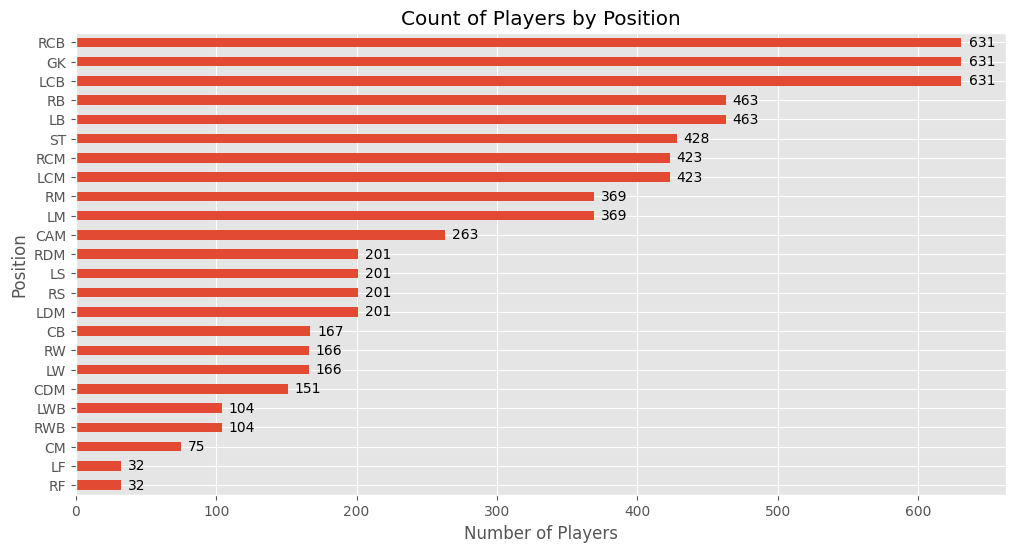

In [485]:
# Number of players by position
position_count = df_raw['position'].value_counts().sort_values(ascending=True)

ax = position_count.plot(kind='barh', figsize=(12, 6))
plt.title('Count of Players by Position')
plt.xlabel('Number of Players')
plt.ylabel('Position')

# Add numbers on the right side of each bar
for i, v in enumerate(position_count):
    ax.text(v + 5, i, str(v), ha='left', va='center')

plt.show()

Let's check if the main player characteristics differ between positions.

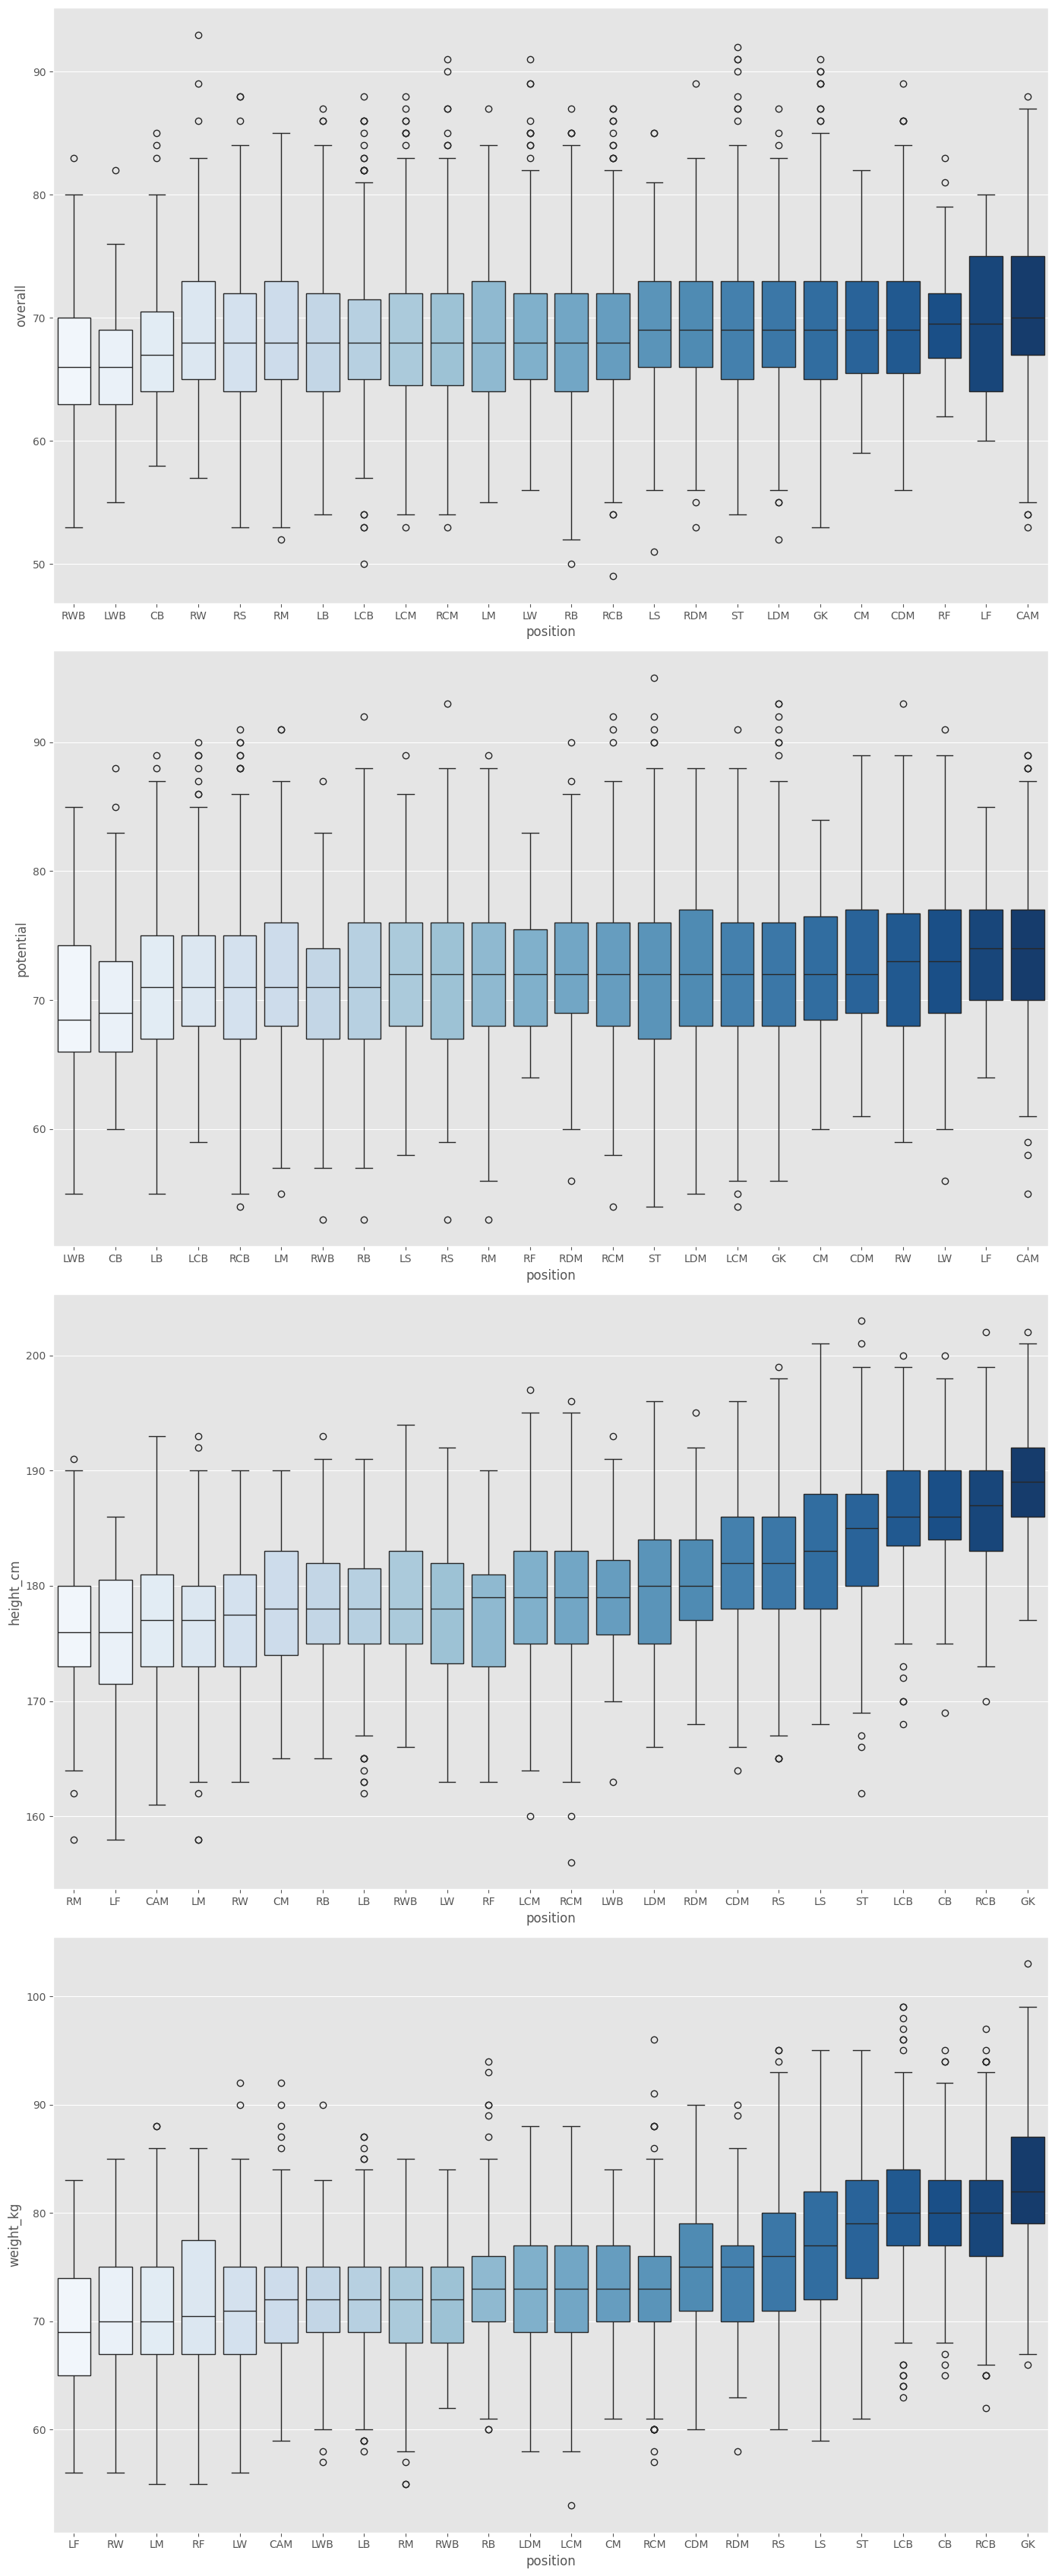

In [486]:
# Calculate the median overall for each position
median_overall = df_raw.groupby('position')['overall'].median().sort_values(ascending=True)

# Calculate the meadian potential for each position
median_potential = df_raw.groupby('position')['potential'].median().sort_values(ascending=True)

# Calculate the meadian height for each position
median_heights = df_raw.groupby('position')['height_cm'].median().sort_values(ascending=True)

# Calculate the meadian weight for each position
median_weights = df_raw.groupby('position')['weight_kg'].median().sort_values(ascending=True)

# Create a subplot with two axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 34))

# Plot the boxplot for overall on the first axis
sns.boxplot(ax=axes[0], x='position', y='overall', data=df_raw, palette='Blues', order=median_overall.index)

# Plot the boxplot for potential on the second axis
sns.boxplot(ax=axes[1], x='position', y='potential', data=df_raw, palette='Blues', order=median_potential.index)

# Plot the boxplot for height on the third axis
sns.boxplot(ax=axes[2], x='position', y='height_cm', data=df_raw, palette='Blues', order=median_heights.index)

# Plot the boxplot for weight on the fourth axis
sns.boxplot(ax=axes[3], x='position', y='weight_kg', data=df_raw, palette='Blues', order=median_weights.index)

# Adjust layout
plt.tight_layout()
plt.show()

While for overall and potential columns the difference is quite small among different positions, players height and weight are very different for some positions.

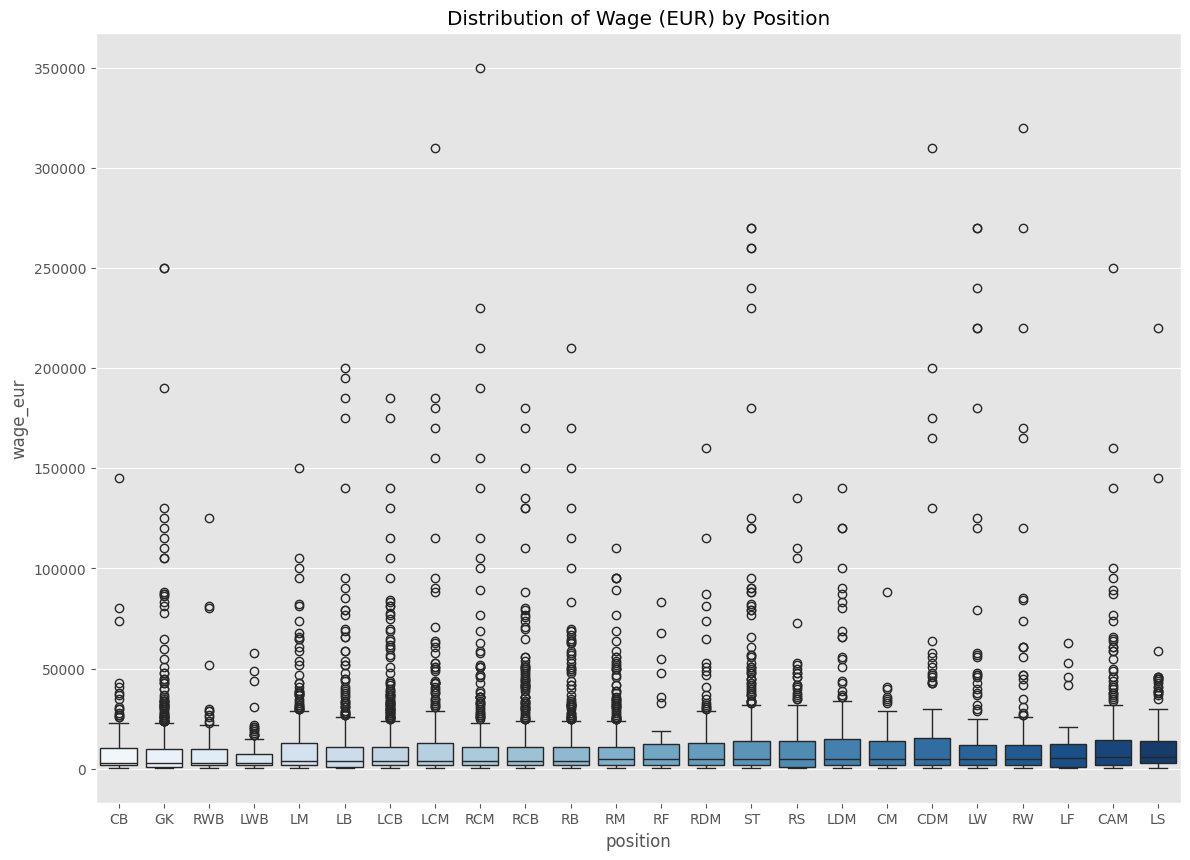

In [487]:
# Calculate the median wage for each position
median_wage_eur = df_raw.groupby('position')['wage_eur'].median().sort_values(ascending=True)

## Create a boxplot to visualize the distribution of 'wage_eur' by 'position'
plt.figure(figsize=(14, 10))
sns.boxplot(x='position', y='wage_eur', data=df_raw, palette='Blues', order=median_wage_eur.index)
plt.title('Distribution of Wage (EUR) by Position')
plt.show()

It's difficult to compare wage_eur median values based on the chart above, as the values range is very big. Let's check the table of meadian wage_eur by position:

In [488]:
df_raw.groupby('position')['wage_eur'].median().reset_index().sort_values(by='wage_eur', ascending=False)

,position,wage_eur
0,CAM,6000.0
11,LS,6000.0
9,LF,5500.0
21,RW,5000.0
20,RS,5000.0
19,RM,5000.0
18,RF,5000.0
17,RDM,5000.0
12,LW,5000.0
8,LDM,5000.0


There is a difference in the medium wage_eur across different positions.

Top 5 positions with the highest median wage:
- CAM: 6000.0 EUR
- LS: 6000.0 EUR
- LF: 5500.0 EUR
- RW: 5000.0 EUR
- RS: 5000.0 EUR

Positions with the lowest median wage of 3000.0 EUR: CB, LWB, GK, RWB

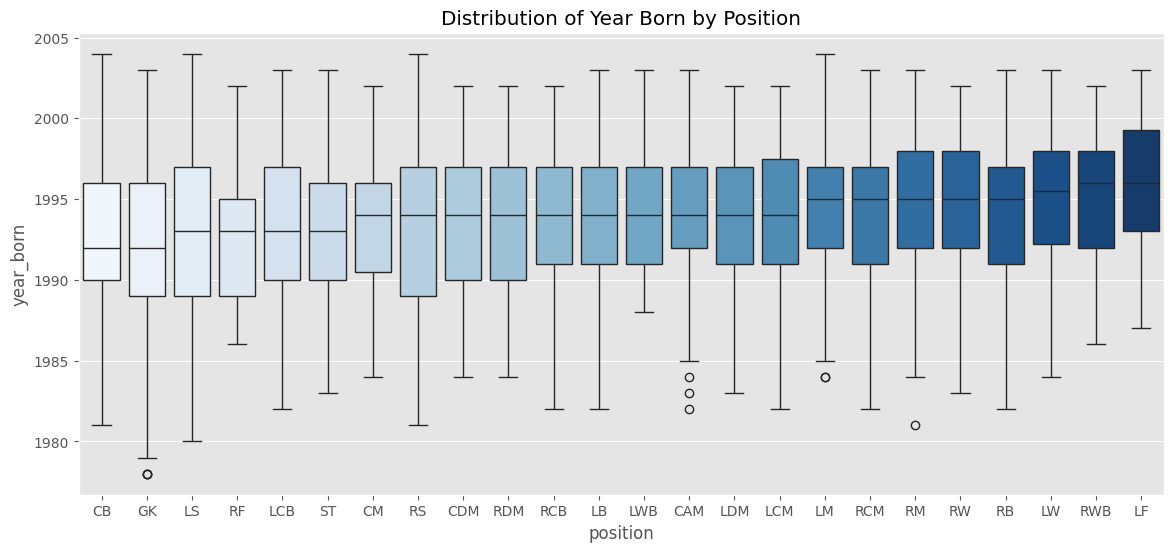

In [489]:
# Create a boxplot of year_born by position
median_year = df_raw.groupby('position')['year_born'].median().sort_values(ascending=True)

plt.figure(figsize=(14, 6))
sns.boxplot(x='position', y='year_born', data=df_raw, palette='Blues', order=median_year.index)

plt.title('Distribution of Year Born by Position')
plt.show()

It is shown in the chart above that CB and GK are usually the youngest players, while LF, RWB, and LW are the oldest ones.

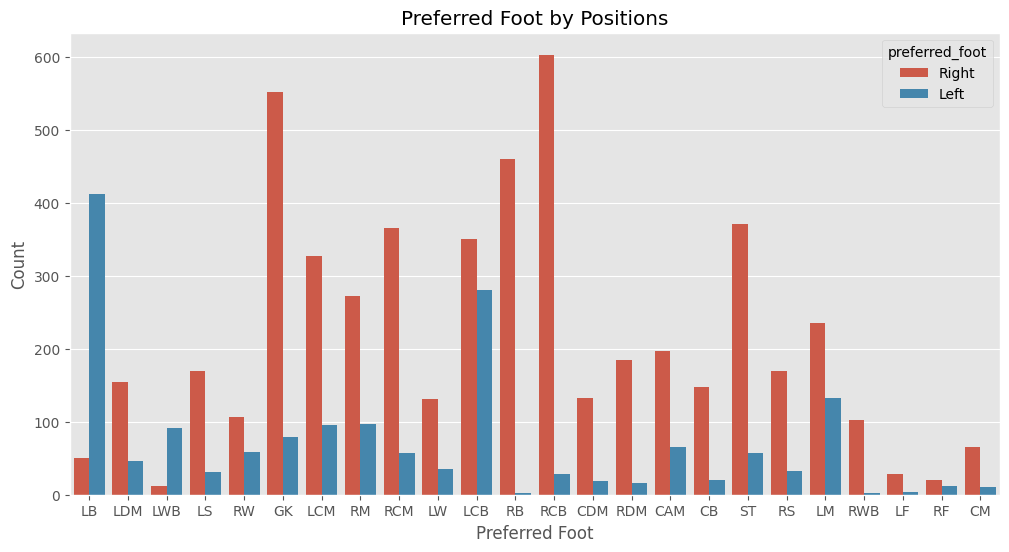

In [490]:
# Create a count plot to visualize the distribution of preferred_foot across positions
plt.figure(figsize=(12, 6))
sns.countplot(x='position', hue='preferred_foot', data=df_raw)
plt.title('Preferred Foot by Positions')
plt.xlabel('Preferred Foot')
plt.ylabel('Count')
plt.show()

Only players at LB and LCB have high share of Left as a preferred foot. Taking this into account may help identify positions more precise.

Let's check if players of some nationalities are more common for some positions. The best way to check the relationships between two categorical variables is creating a heatmap:

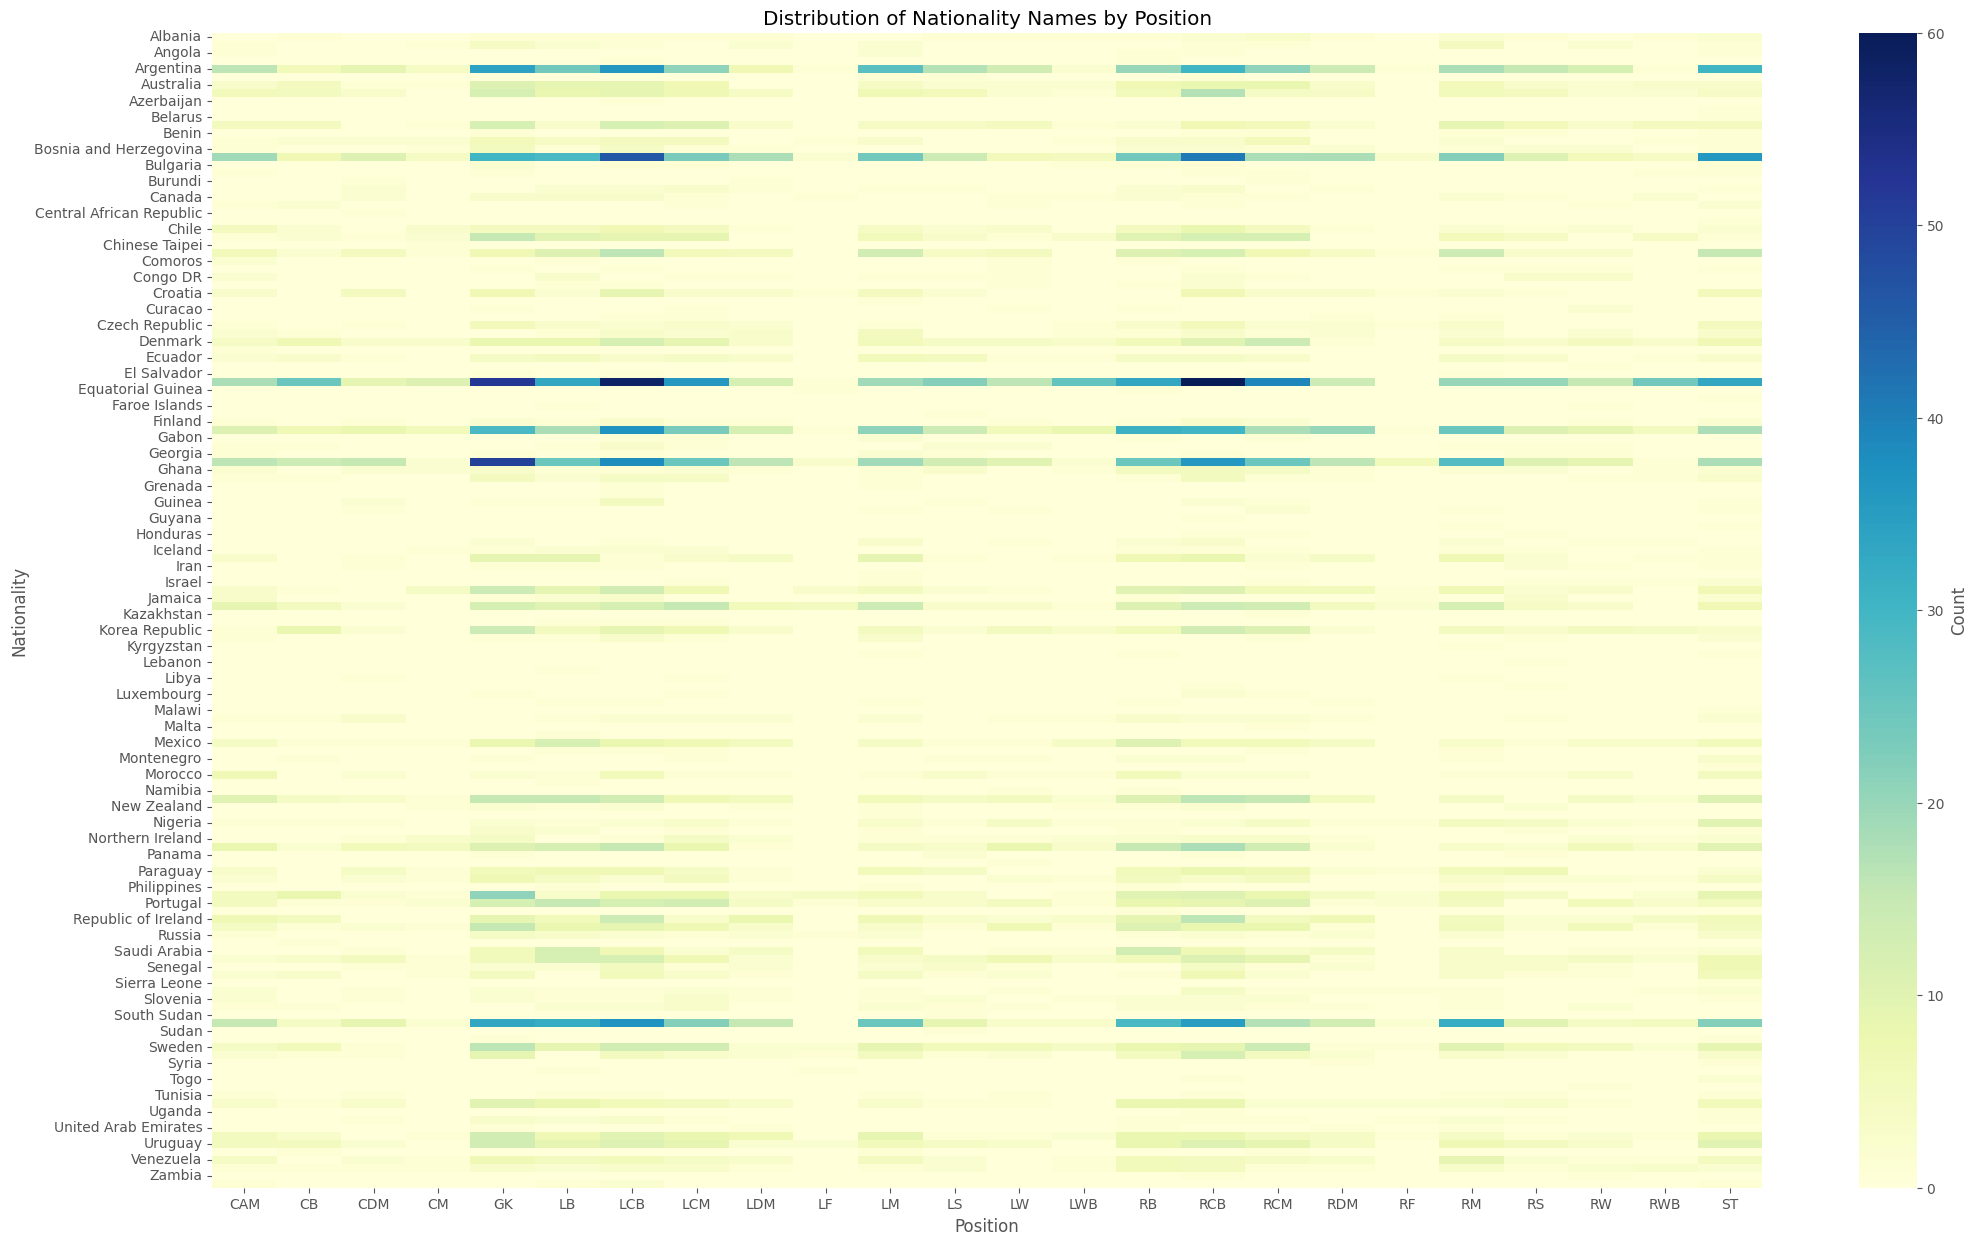

In [491]:
# Create a crosstab to count the occurrences of each nationality by position
cross_tab = pd.crosstab(df_raw['nationality_name'], df_raw['position'])

# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(cross_tab, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Distribution of Nationality Names by Position')
plt.xlabel('Position')
plt.ylabel('Nationality')
plt.show()

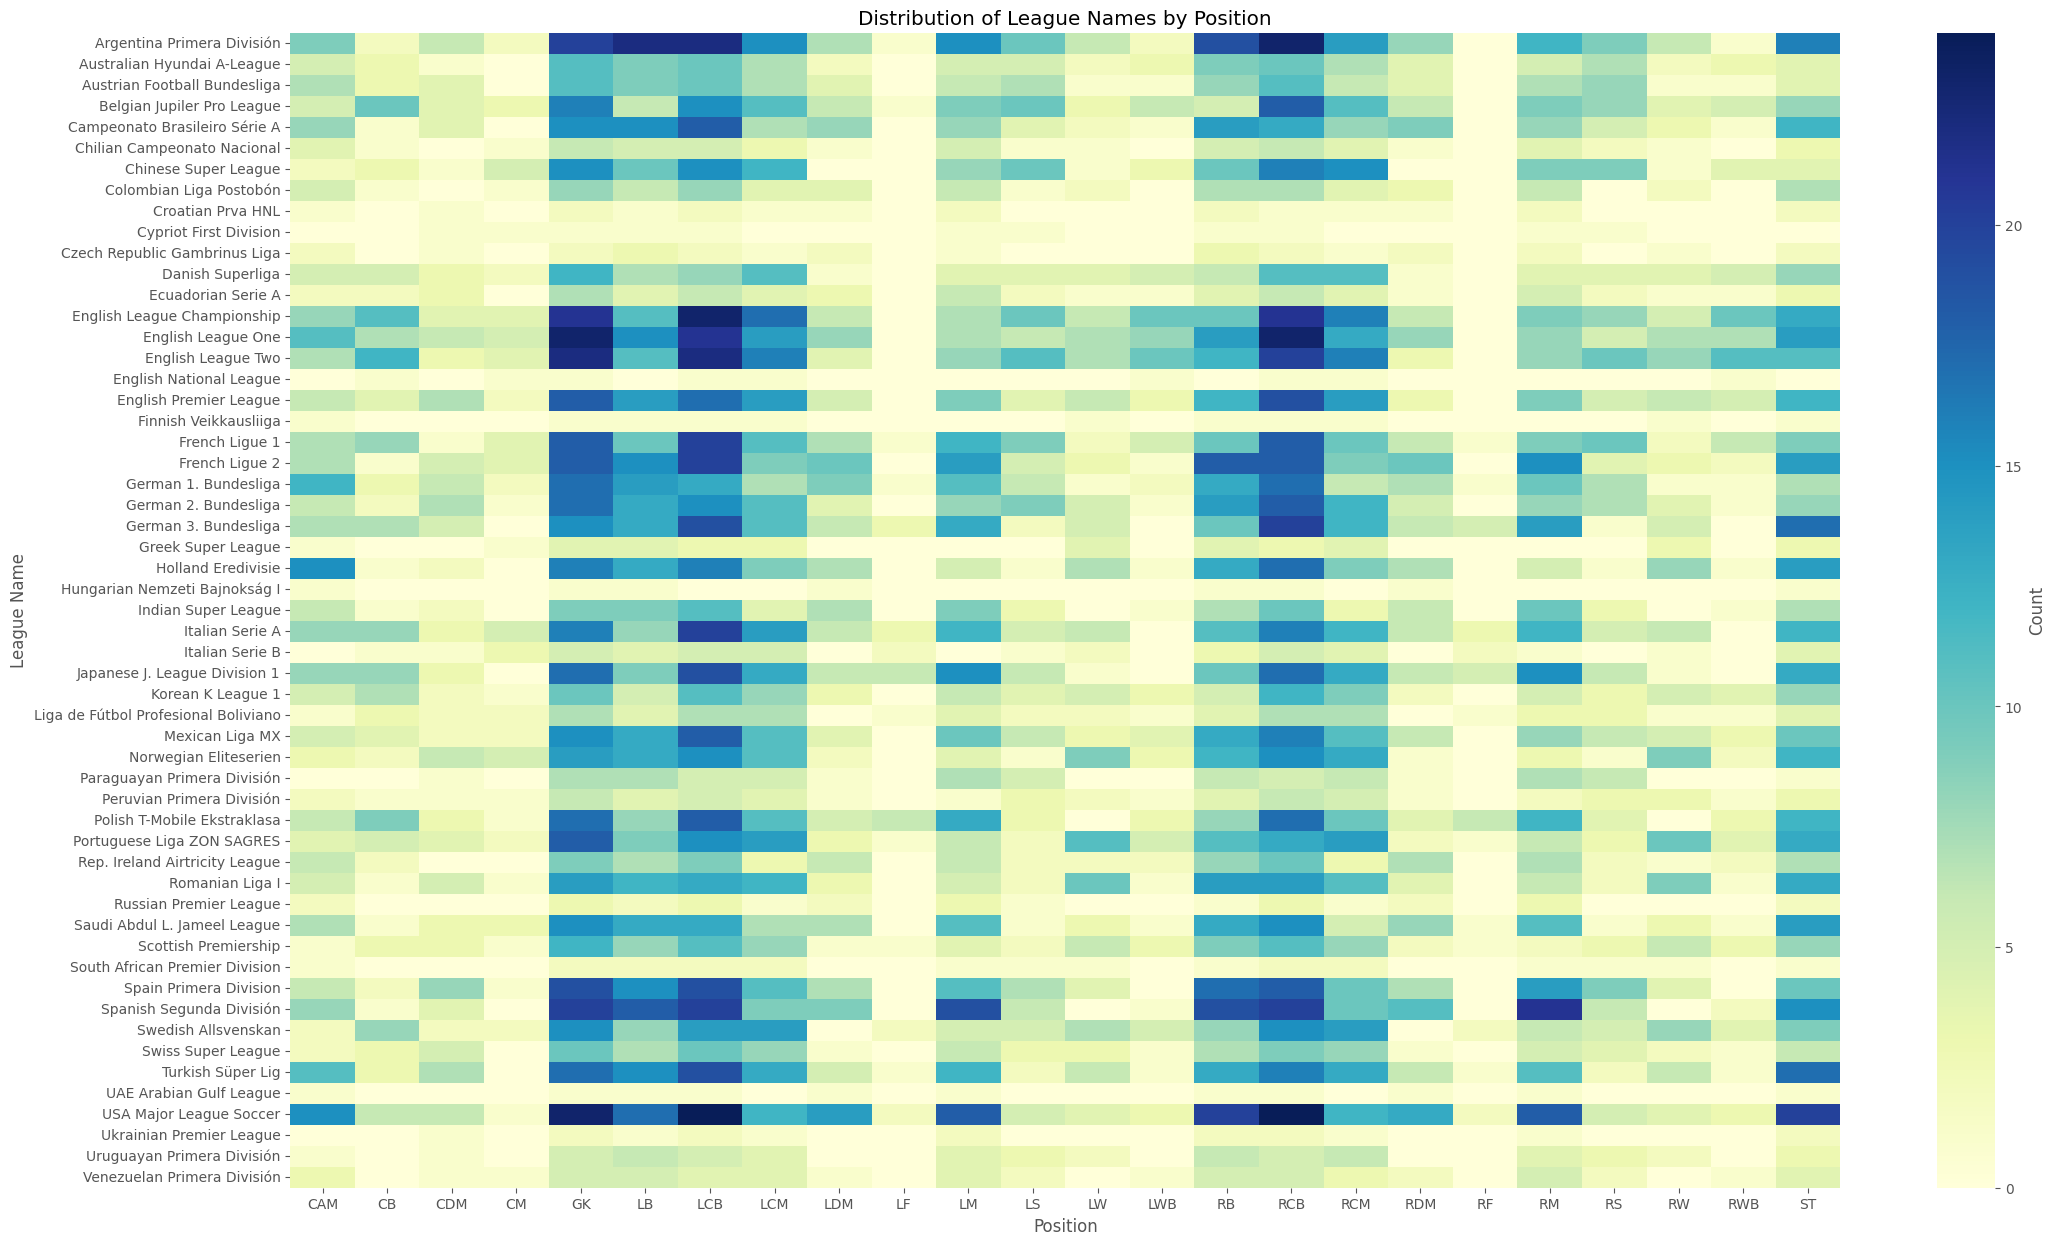

In [492]:
# Create a crosstab to count the occurrences of each league_name by position
cross_tab = pd.crosstab(df_raw['league_name'], df_raw['position'])

# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(cross_tab, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Distribution of League Names by Position')
plt.xlabel('Position')
plt.ylabel('League Name')
plt.show()

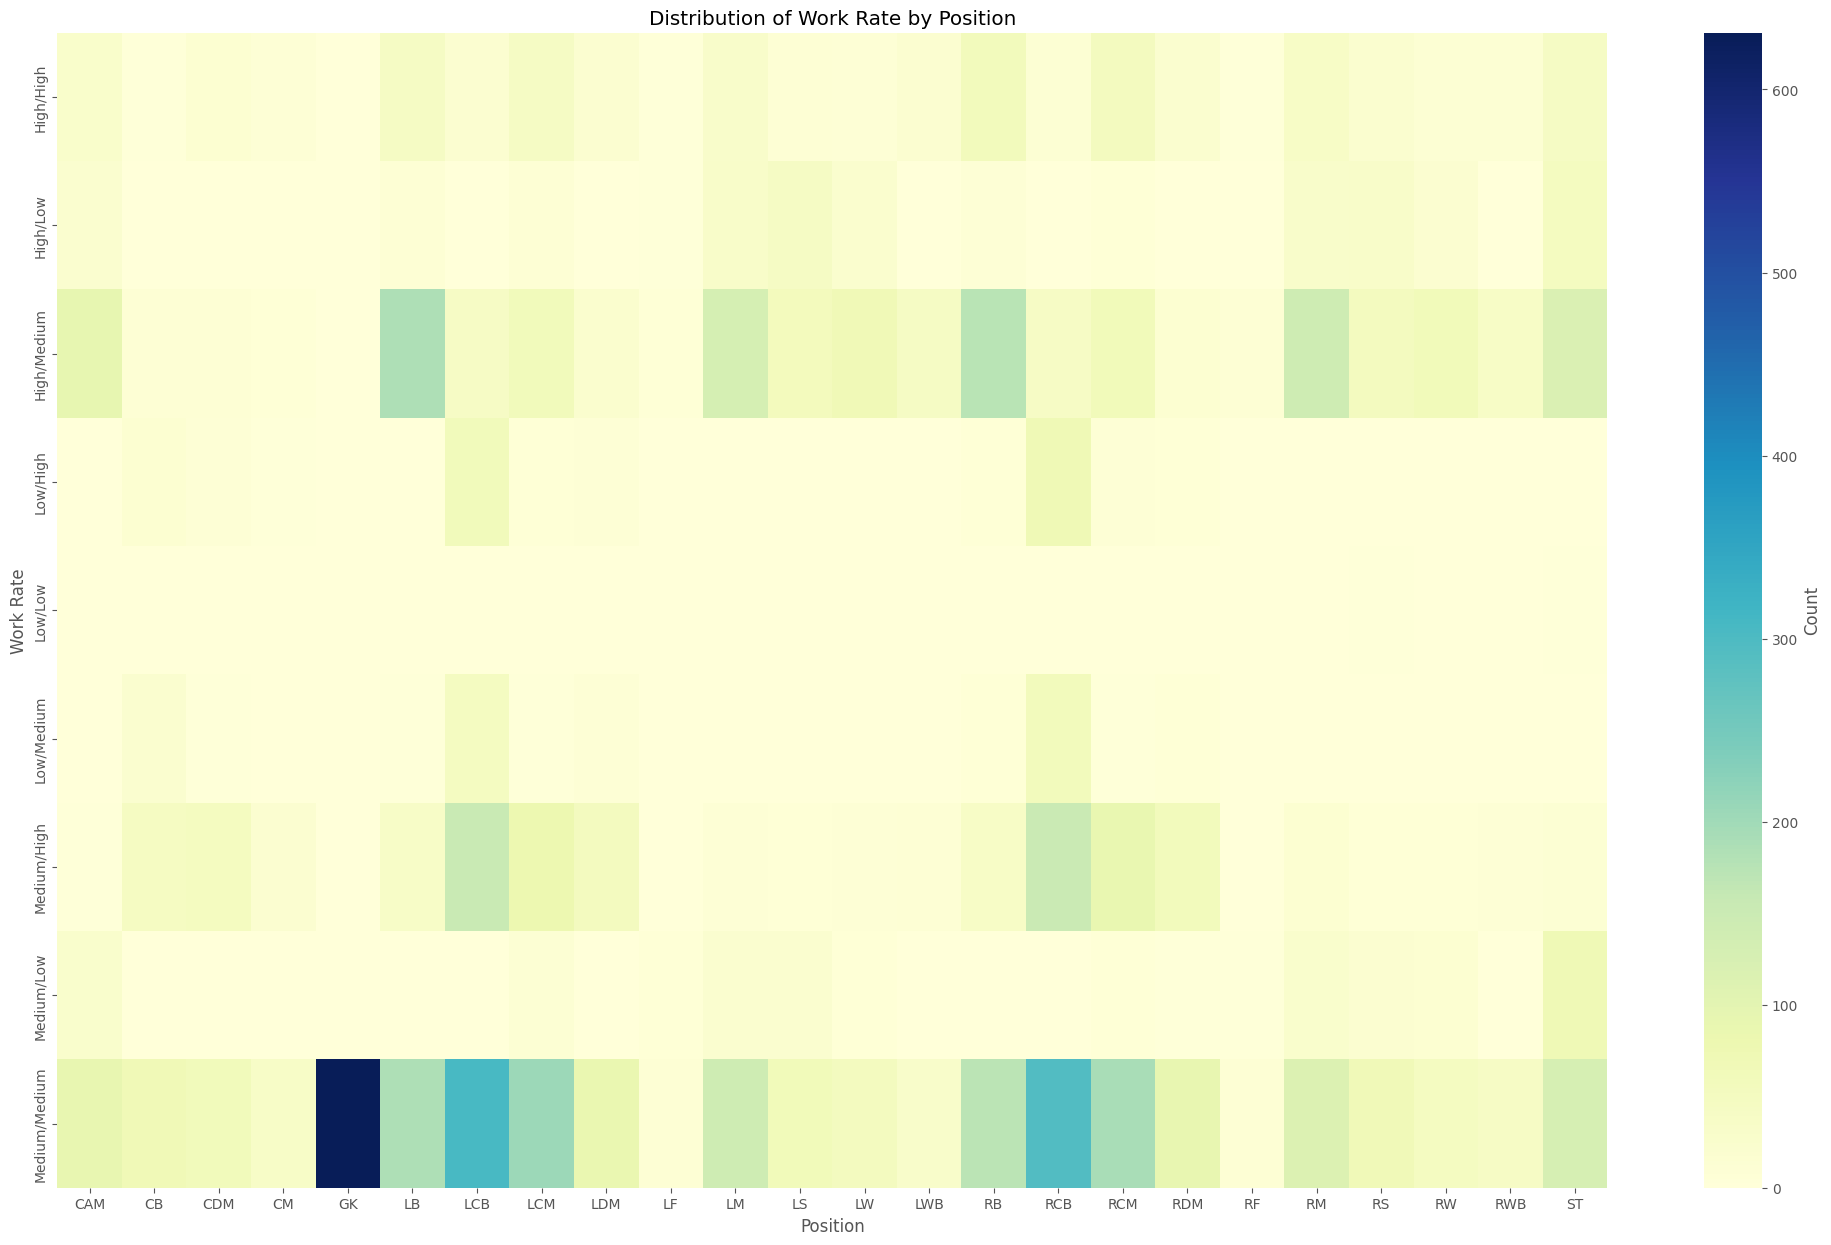

In [493]:
# Create a crosstab to count the occurrences of each work_rate by position
cross_tab = pd.crosstab(df_raw['work_rate'], df_raw['position'])

# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(cross_tab, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Distribution of Work Rate by Position')
plt.xlabel('Position')
plt.ylabel('Work Rate')
plt.show()

In [494]:
# TODO: change heatmaps to show the percentage of all players of the same position

In [495]:
# Add table for all numerical variables summary by position
grouped_data = df_raw[cols + ['position']].groupby(by='position').agg('mean').reset_index().T

print("Summary of numerical variables (mean) by positions:")
display(grouped_data)

Summary of numerical variables (mean) by positions:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
position,CAM,CB,CDM,CM,GK,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
overall,70.61597,67.616766,69.774834,69.48,69.545166,68.285097,68.36767,68.704492,69.477612,69.3125,68.712737,69.41791,69.240964,66.365385,68.388769,68.36767,68.489362,69.164179,70.09375,68.891599,68.58209,69.361446,66.423077,69.640187
potential,73.897338,70.05988,73.15894,72.173333,72.424723,71.419006,71.611727,72.049645,72.537313,74.0625,72.121951,72.482587,73.13253,69.740385,71.613391,71.51664,71.976359,72.452736,72.3125,72.319783,71.905473,73.090361,70.913462,72.081776
value_eur,6477794.676806,2475692.771084,5129039.735099,3654133.333333,3827694.136292,3795939.524838,3181830.427892,4357647.754137,5084626.865672,5335156.25,4827289.9729,4509075.0,7337289.156627,1936250.0,3746004.319654,3730641.838352,4296643.026005,4391940.298507,4775000.0,4316964.769648,4470995.024876,6327650.60241,2516826.923077,5964964.953271
release_clause_eur,11882505.976096,4660183.544304,9980034.246575,6699652.777778,7521306.020067,7174192.307692,6019996.621622,8391029.776675,9073373.056995,9051892.857143,8943424.068768,8428966.292135,14519561.290323,3444438.77551,6808842.696629,7156971.99341,8186650.990099,8041410.25641,8605096.774194,8097577.586207,8789084.210526,12181522.292994,4044154.639175,11147733.333333
wage_eur,14906.653992,8974.850299,16554.635762,10849.333333,10505.942948,11254.427646,10509.904913,12364.420804,13528.109453,11673.4375,11143.766938,12570.39801,18804.518072,6845.673077,11004.967603,10601.505547,12095.862884,11545.771144,14410.9375,10898.509485,11920.895522,17726.506024,9150.961538,16309.696262
weak_foot,3.365019,2.814371,3.046358,3.053333,2.562599,2.805616,2.812995,3.096927,3.099502,3.3125,3.208672,3.308458,3.295181,2.807692,2.978402,2.792393,3.111111,3.104478,3.28125,3.205962,3.154229,3.331325,3.028846,3.189252
international_reputation,1.258555,1.107784,1.18543,1.173333,1.191759,1.099352,1.136292,1.158392,1.164179,1.3125,1.132791,1.144279,1.204819,1.028846,1.107991,1.115689,1.115839,1.144279,1.21875,1.105691,1.149254,1.216867,1.048077,1.247664
height_cm,177.39924,186.491018,181.642384,178.493333,188.988906,178.008639,186.470681,178.579196,179.656716,175.59375,176.704607,182.850746,177.554217,179.009615,178.239741,186.362916,178.843972,180.38806,177.34375,176.406504,181.741294,177.012048,178.586538,183.988318
weight_kg,71.988593,80.0,75.125828,72.893333,82.740095,72.222462,80.03645,72.938534,73.268657,69.75,70.691057,77.0199,71.216867,71.884615,72.792657,79.843106,73.035461,74.114428,72.03125,71.176152,76.373134,71.283133,72.144231,78.745327


# Data Preparation

Recommendations based on data exploration:
- Impute pace, shooting, passing, dribbling, defending, player_tags for GK with 0
- Remove the body_type column as it's basically the combination of height_cm and weight_cm
- Remove outliers in wage_eur and value_eur columns. Also check the distribution after the outliers are removed
- Decide if it's needed to remove outloiers in overall, potential, weight_kg, height_cm columns
- Check the correlationg matrix for deciding which columns to drop
- Transform birthday_date to year/age -> I created the column "year_born"


Idea for imputation - it might make sence to do it for each position separately.


## Drop the columns with more than 80% of missing values

In [496]:
# Drop columns club_loaned_from, nation_jersey_number, player_tags
df_raw = df_raw.drop(columns=['club_loaned_from', 'nation_jersey_number', 'player_tags'])

## Check for outliers

## Impute missing values

In [497]:
df_raw.loc[df_raw['goalkeeping_speed'] > 0, 'position'].value_counts() # Imputation: 0, field players have no goalkeeping speed.

position
GK    631
Name: count, dtype: int64

Since we see that the NAs in the goalkeeping speed column are not missing at random but rather only missing for field players (Non-GK), we can make accurate predictions for GKs based on that.

In [498]:
goalkeeper_pred = df_raw[6895:].apply(lambda x: pd.Series({'id': x['id'], 'position': 'GK' if x['goalkeeping_speed'] > 0 else x['position']}), axis=1).dropna()

goalkeeper_pred['id'] = goalkeeper_pred['id'].astype(int)

We then remove the rows with GK from our data by just keeping those where goalkeeping speed has NAs.

In [499]:
df_raw = df_raw[pd.isna(df_raw['goalkeeping_speed'])]

In [500]:
columns_to_impute = ['value_eur','pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

knn_imputer = KNNImputer(n_neighbors=50)  

imputed_data = knn_imputer.fit_transform(df_raw[columns_to_impute])

df_raw[columns_to_impute] = imputed_data

We also exclude all columns from our features that are exclusively related to Goalkeepers: 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'.

In [501]:
features = ['overall', 'potential', 'value_eur', 'wage_eur','height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'weak_foot', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'work_rate',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle','position']

In [502]:
df = df_raw[features]

In [503]:
def one_hot_encoding(data, column):
    data = data.copy() # create deep copy of data

    dummy = pd.get_dummies(data[column]).astype(int) # get dummies
    data = pd.concat([data, dummy], axis=1) # add dummy columns to dataframe 
    data = data.drop(columns = column)

    return data

In [504]:
df['weak_foot']

0       5
1       3
2       3
3       3
4       2
       ..
7657    3
7658    2
7659    4
7660    3
7661    3
Name: weak_foot, Length: 6961, dtype: int64

In [505]:
df = one_hot_encoding(df, 'weak_foot')
df = df.rename(columns={1:'wf_one_star', 2:'wf_two_stars', 3:'wf_three_stars', 4:'wf_four_stars', 5:'wf_five_stars'})

df = one_hot_encoding(df, 'skill_moves')
df = df.rename(columns={2:'sm_two_stars', 3:'sm_three_stars', 4:'sm_four_stars', 5:'sm_five_stars'})

In [506]:
df

,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_jersey_number,preferred_foot,pace,shooting,passing,dribbling,defending,physic,work_rate,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,position,wf_one_star,wf_two_stars,wf_three_stars,wf_four_stars,wf_five_stars,sm_two_stars,sm_three_stars,sm_four_stars,sm_five_stars
0,71,71,1400000.0,10000,176,73,29,Right,70.0,52.0,60.0,70.0,67.0,66.0,Medium/High,...,58,66,65,66,65,LB,0,0,0,0,1,0,1,0,0
1,65,71,1000000.0,2000,183,73,4,Right,65.0,38.0,58.0,60.0,63.0,67.0,Medium/Medium,...,46,59,65,61,58,LDM,0,0,1,0,0,1,0,0,0
2,65,77,1600000.0,2000,178,69,19,Left,79.0,35.0,58.0,66.0,59.0,64.0,High/Medium,...,31,65,60,58,59,LWB,0,0,1,0,0,0,1,0,0
3,72,72,2300000.0,5000,188,81,9,Right,64.0,74.0,51.0,68.0,24.0,76.0,High/Medium,...,75,75,16,22,19,LS,0,0,1,0,0,0,1,0,0
4,65,65,525000.0,3000,179,74,30,Left,74.0,53.0,59.0,53.0,61.0,69.0,Medium/High,...,52,58,64,61,58,LB,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,72,72,2300000.0,17000,165,65,3,Left,82.0,66.0,68.0,75.0,34.0,40.0,Medium/Low,...,70,64,30,33,32,NaN,0,0,1,0,0,0,1,0,0
7658,68,74,1700000.0,2000,180,70,2,Right,68.0,44.0,50.0,49.0,65.0,81.0,Low/High,...,37,57,64,65,63,NaN,0,1,0,0,0,1,0,0,0
7659,65,65,700000.0,6000,185,80,9,Right,65.0,64.0,52.0,61.0,28.0,84.0,Low/Low,...,56,61,22,26,25,NaN,0,0,0,1,0,0,1,0,0
7660,81,81,12500000.0,18000,183,76,30,Right,63.0,57.0,62.0,59.0,83.0,81.0,Medium/High,...,45,79,84,83,80,NaN,0,0,1,0,0,1,0,0,0


In [507]:
df['wr_high_def'] = df['work_rate'].str.contains('High/').astype(int)
df['wr_low_def'] = df['work_rate'].str.contains('Low/').astype(int)

df['wr_high_atk'] = df['work_rate'].str.contains('/High').astype(int)
df['wr_low_atk'] = df['work_rate'].str.contains('/Low').astype(int)

In [508]:
# Apply label encoding
encoder = LabelEncoder()
df['preferred_foot'] = encoder.fit_transform(df['preferred_foot'])
df['position'] = encoder.fit_transform(df['position'])


In [509]:
# tr = df[:6895]
# te = df[6895:]

tr = df[:6264]
te = df[6264:]
##### can we split it like this??? don't we need to do a random train/test split 80/20 %?

# Model Selection

NOTE: we need to split train set into train/test subtests to avoid select best model and then we retrain on all data (and have hyperparameter tuning done solely on best classifier)


### Random Forest Classifier

In [510]:
features = ['overall', 'potential', 'value_eur', 'wage_eur','height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle','position', 'wf_one_star', 'wf_two_stars', 
            'wf_three_stars', 'wf_four_stars', 'wf_five_stars', 'sm_two_stars', 'sm_three_stars', 'sm_four_stars', 'sm_five_stars']

In [511]:
X = tr[features].drop('position', axis=1)
y = tr['position']

x_subtrain, x_val, y_subtrain, y_val = train_test_split(X, y, test_size=0.20, random_state=42)


In [512]:
best_model = RandomForestClassifier(random_state=42).fit(x_subtrain, y_subtrain) # smote 
y_pred = best_model.predict(x_val)

accuracy = accuracy_score(y_val, y_pred) # accuracy per category # confusion matrix
f1 = f1_score(y_val, y_pred, average='micro')

print('Accuracy: ', accuracy)
print('F1-score: ', f1)

Accuracy:  0.40861931364724663
F1-score:  0.40861931364724663


### Gradient Boosting Classifier

In [513]:
best_model = GradientBoostingClassifier(random_state=42).fit(x_subtrain, y_subtrain) # xg boost
y_pred = best_model.predict(x_val)

accuracy = accuracy_score(y_val, y_pred) 
f1 = f1_score(y_val, y_pred, average='micro')

print('Accuracy: ', accuracy)
print('F1-score: ', f1)

Accuracy:  0.40782122905027934
F1-score:  0.40782122905027934


### Logistic Regression

In [514]:
best_model = LogisticRegression(multi_class="multinomial").fit(x_subtrain, y_subtrain) # xg boost
y_pred = best_model.predict(x_val)

accuracy = accuracy_score(y_val, y_pred) 
f1 = f1_score(y_val, y_pred, average='micro')

print('Accuracy: ', accuracy)
print('F1-score: ', f1)

Accuracy:  0.08778930566640064
F1-score:  0.08778930566640064


### Stacking Regressor

In [515]:
# estimators = [('rf', RandomForestClassifier(random_state=42), 'gb')]
# reg = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# best_model = reg.fit(x_subtrain, y_subtrain)
# y_pred = best_model.predict(x_val)

# accuracy = accuracy_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred, average='micro')

# print('Accuracy: ', accuracy)
# print('F1-score: ', f1)

### Random Forest Classifier

Random Forest hyperparameter tuning

In [516]:
X_train = tr[features].drop('position', axis=1)
y_train = tr['position']

X_test = te[features].drop('position', axis=1)

In [517]:
from scipy.stats import randint

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=2)

# Define the hyperparameter grid to search
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=2)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X, y)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy: ", random_search.best_score_)

rf_best_params = random_search.best_params_

Best Hyperparameters: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 90}
Best Accuracy:  0.4007008100686149


In [518]:
rf_best_params

{'bootstrap': True,
 'max_depth': 15,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 90}

In [519]:
rf_best_model = RandomForestClassifier(**rf_best_params).fit(X_train, y_train)

In [520]:
feature_importances = rf_best_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

display(feature_importance_df.head(60))

,Feature,Importance
7,preferred_foot,0.070636
14,attacking_crossing,0.045626
16,attacking_heading_accuracy,0.043483
12,defending,0.039189
36,mentality_positioning,0.038330
35,mentality_interceptions,0.038182
42,defending_sliding_tackle,0.035060
41,defending_standing_tackle,0.034835
32,power_strength,0.032060
15,attacking_finishing,0.030135


In [521]:
rf_preds = rf_best_model.predict(X_test)

decoded_rf_preds = encoder.inverse_transform(rf_preds)

In [522]:
decoded_rf_preds

array(['RB', 'LCB', 'ST', 'CAM', 'RM', 'RB', 'LCM', 'RCM', 'RCB', 'ST',
       'CAM', 'LB', 'RCB', 'RCB', 'LCM', 'LB', 'ST', 'RB', 'RCM', 'RM',
       'ST', 'LCM', 'RB', 'RCB', 'LB', 'LCM', 'RB', 'LB', 'LM', 'RCB',
       'RM', 'RCB', 'LCM', 'RCB', 'LCM', 'LM', 'RCB', 'RCM', 'ST', 'RCB',
       'RB', 'LB', 'RCB', 'RCM', 'LB', 'ST', 'LM', 'ST', 'RB', 'RB', 'LB',
       'ST', 'LB', 'ST', 'ST', 'RCB', 'CAM', 'CAM', 'RCM', 'RB', 'RCB',
       'LCB', 'ST', 'LCM', 'LCM', 'LCB', 'RB', 'RB', 'RCM', 'RCM', 'RM',
       'RCB', 'LM', 'ST', 'RCM', 'RB', 'RCM', 'RCB', 'LM', 'RCB', 'LB',
       'RCM', 'RCM', 'ST', 'RM', 'RB', 'LM', 'RCM', 'LM', 'RCB', 'ST',
       'ST', 'LCB', 'RM', 'ST', 'LCB', 'LB', 'RCM', 'LCM', 'RCB', 'RM',
       'ST', 'LCB', 'LM', 'RB', 'ST', 'LCM', 'RCB', 'RCB', 'LM', 'ST',
       'RB', 'LCB', 'LB', 'RCM', 'ST', 'RB', 'LCB', 'LCM', 'RM', 'RCM',
       'RB', 'ST', 'RCM', 'RB', 'LCM', 'RM', 'RM', 'ST', 'RCM', 'LB',
       'ST', 'RCM', 'RM', 'LM', 'LB', 'RCM', 'ST', 'LCM', 'RCB'

In [523]:
decoded_rf_preds = pd.DataFrame({"id": df_raw[6264:]["id"], "position": decoded_rf_preds})

rf_merged_df = pd.merge(goalkeeper_pred, decoded_rf_preds, how='outer', on='id')

# Sort the merged DataFrame based on the order in test_raw
rf_result = pd.merge(test_raw['id'], rf_merged_df, how='left', on='id')

rf_result['position'] = rf_result['position_x'].fillna(rf_result['position_y'])

In [527]:
rf_result['position'].value_counts()

position
RCB    111
ST     100
RB      83
RCM     79
LB      79
GK      70
LCB     62
LCM     53
RM      51
LM      42
CAM     25
RDM      6
RS       2
RW       1
LS       1
LDM      1
CDM      1
Name: count, dtype: int64

In [528]:
#Produce .csv for kaggle testing 

test_predictions_submit = pd.DataFrame({"id": test_raw["id"], "position": rf_result['position']})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)